In [1]:
# !git clone -b siamese https://github.com/wagner1986/singular-points.git singular_points
# !pip install kornia e2cnn

# !pwd
# %cd /content/singular_points
# !pwd

In [2]:
import torch
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Detector e Descritor

- computei o detector e descritor de um batch para criar massa de dados para a rede siamesa

In [3]:
import torch
from config import args, device
from predict.predict_utils import load_model_trained, predict_single_points,extract_features_with_box
import torchvision
from torchvision.transforms import transforms, InterpolationMode
from utils.my_dataset import FibersDataset, WoodsDataset
from utils import create_circular_mask
from matplotlib import pyplot as plt
import numpy as np
from training import KeyEqGroup, KeyPointsSelection
torch.__version__


def custom_config(args):
    args.img_size = 180
    args.dim_first = 2
    args.dim_second = 3
    args.dim_third = 4
    args.batch_size = 15
    args.margin_loss = 2.0
    args.border  = 15
    args.nms_size = 40 # normal é 10, alterei so pra avaliar o match
    args.box_size = 31
    args.exported = False
    return args

def concatenate_mini_batches_feat_orien(batch_result):
    mini_feat_batch_concat = []
    mini_orien_batch_concat = []
    
    for i, (boxs, mini_feat_batch, mini_orien_batch) in enumerate(batch_result):
        mini_feat_batch_concat.append(mini_feat_batch)
        mini_orien_batch_concat.append(mini_orien_batch)

    mini_feat_batch_concat = torch.cat(mini_feat_batch_concat, dim=0)
    mini_orien_batch_concat = torch.cat(mini_orien_batch_concat, dim=0)

    mini_dataloader = torch.stack([mini_feat_batch_concat, mini_orien_batch_concat], dim=1)

    return mini_dataloader


args = custom_config(args)
n_bin = 6
transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.Flowers102(root='./data/datasets', split='test',
                                            download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                            shuffle=False, num_workers=2)




MODEL_PATH = "./data/models/model_flowers_ssim.pt"

single_point_model = load_model_trained(args,device,path=MODEL_PATH)
iterator=iter(testloader)
batch = next(iterator)
img_batch, labels =batch
print(len(img_batch),labels) #4

c:\Users\renga\PycharmProjects\singular_points\venv\lib\site-packages\e2cnn\nn\modules\r2_conv\basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  full_mask[mask] = norms.to(torch.uint8)


Já foi treinado
epoca 100 loss 3.536601146062214
15 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### Segementa todas as features de batch só

mini_dataloader  torch.Size([136, 2, 31, 31])


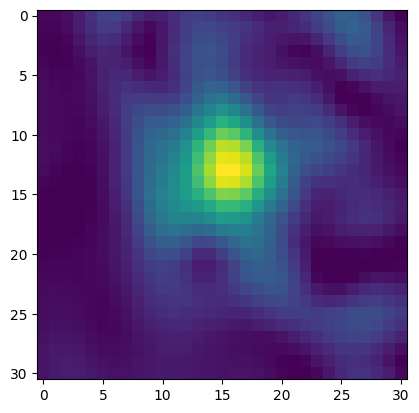

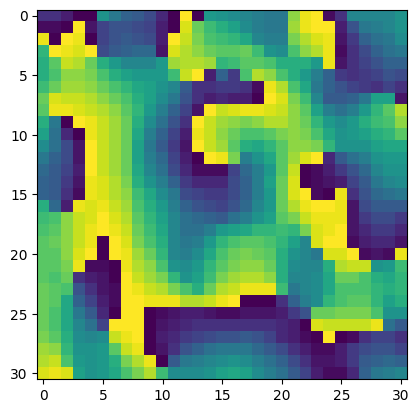

In [4]:
feature,orien1 = predict_single_points(single_point_model,batch)
batch_result,coords = extract_features_with_box(feature,orien1)

mini_dataloader = concatenate_mini_batches_feat_orien(batch_result)
print('mini_dataloader ',mini_dataloader.shape)

plt.imshow(mini_dataloader[0,0,:,:].cpu().detach())
plt.show()
plt.imshow(mini_dataloader[0,1,:,:].cpu().detach())
plt.show()

#### Dividi o array em batch de train e test de tamanho 10

In [5]:
import torch
from torch.utils.data import DataLoader, random_split

# Definindo o tamanho do lote desejado
batch_size = 25

# Dividindo o tensor em conjuntos de treinamento e teste
train_ratio = 0.6
train_size = int(train_ratio * len(mini_dataloader))
test_size = len(mini_dataloader) - train_size

train_tensor, test_tensor = random_split(mini_dataloader, [train_size, test_size])

# Criando os dataloaders para treinamento e teste
train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=True)

# Verificando o tamanho dos conjuntos de treinamento e teste (em número de lotes)
print(len(train_loader))  # Saída: 64 (80% de 800 dividido por 10)
print(len(test_loader))  # Saída: 16 (20% de 800 dividido por 10)


4
3


### Define arquitetura do modelo de rede siamesa

In [6]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

In [7]:
from e2cnn import gspaces
from e2cnn import nn as enn    #the equivariant layer we need to build the model
from torch import nn
class Feature(nn.Module):
    def __init__(self,n_channel=2) -> None:
        super().__init__()
        r2_act = gspaces.Rot2dOnR2(N=36)      

        feat_type_in  = enn.FieldType(r2_act,  n_channel*[r2_act.trivial_repr])
        feat_type_out = enn.FieldType(r2_act, 5*[r2_act.regular_repr])     
        self.input_type = feat_type_in

        self.block1 = enn.SequentialModule(                
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=5, padding=1, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True)
                )
        
        self.pool1 = enn.PointwiseAvgPoolAntialiased(feat_type_out, sigma=0.66, stride=1, padding=0)

        feat_type_in  = self.block1.out_type
        feat_type_out = enn.FieldType(r2_act, 1*[r2_act.regular_repr])
        self.block2 = enn.SequentialModule(                
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=5, padding=2, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True),
                )
        # self.pool2 = enn.PointwiseAvgPool(feat_type_out, 21)
        self.gpool = enn.GroupPooling(feat_type_out)
        
                
    def forward(self,X1)->torch.Tensor:
        x = enn.GeometricTensor(X1, self.input_type)
        n_dim = X1.shape[-1]
        mask = enn.MaskModule(self.input_type, n_dim, margin=2).to(device)
        x = mask(x)
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        # x = self.pool2(x)
        x = self.gpool(x)   
        return x.tensor
    

class Discriminator(nn.Module):
    def __init__(self, n_classes=10) -> None:
        super().__init__()
        #criar camadas densa a partir de x que é uma cnn
        self.dense1 = nn.Linear(2*1*25*25, 256)
        self.dense2 = nn.Linear(256, 128)
        #função de ativação ideal para retornar um valor entre 0 e 1
        self.activation = nn.Sigmoid()

    
    def forward(self,X1,X2)->torch.Tensor:
        flatten_x1 = X1.view(X1.size(0), -1)
        flatten_x2 = X2.view(X2.size(0), -1)
      
        x = torch.cat((flatten_x1,flatten_x2),dim=1)
        x = self.dense1(x)
        x = self.dense2(x)
        # Calculando a diferença entre os embeddings
        # diff = flatten_x1 - flatten_x2
        # Calculando a distância euclidiana
        distance = torch.norm(x, dim=1)
        x = self.activation(distance)
        return x


class Siamesa(nn.Module):
    def __init__(self,n_channel=2) -> None:
            super().__init__()
            self.feature = Feature(n_channel=n_channel)
            self.discriminator = Discriminator()
    
    def forward(self,X1,X2)->torch.Tensor:
        x1 = self.feature(X1)
        x2 = self.feature(X2)
        x = self.discriminator(x1,x2)
        return x


### Metodos para o processo de treinamento

In [8]:
from tqdm import tqdm

#Create methods to train the model
def train_one_epoch(model,train_loader,optimizer,loss_fn,device='cpu'):
    model.train()
    total_loss = 0.

    for data in tqdm(train_loader, desc="Train "):
        data = data.to(device)
        optimizer.zero_grad()            

        #refactor block
        data_pos = random_transform(data)
        output_pos = model(data,data_pos)
        #sift rool data
        data_neg =torch.roll(data_pos, 1, 0)
        output_neg = model(data,data_neg)

        #calculate loss
        loss = loss_fn(output_pos,output_neg)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss/len(train_loader.dataset)

#Create methods to test the model
def test(model,test_loader,loss_fn,device='cpu'):
    model.eval()
    test_loss = 0.
    correct = 0.
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Tests "):
            data = data.to(device)
            
            #refactor block
            data_pos = random_transform(data)
            output_pos = model(data,data_pos)
            #sift rool data
            data_neg =torch.roll(data_pos, 1, 0)
            output_neg = model(data,data_neg)

            test_loss +=  loss_fn(output_pos,output_neg).item()
    return test_loss/len(test_loader.dataset)
    

#Create methods to calculate loss
def loss_fn(output_pos,output_neg):    
    margim = 0.8
    zero = torch.tensor(0.,requires_grad=True).to(output_pos.device)
    loss = output_pos - output_neg + margim
    loss = torch.max(torch.tensor(0),loss)
    # print(loss)
    loss = torch.sum(loss)  # Reduzir para um escalar
    return loss

#Create methods random_transform with kornia with import
import kornia
def random_transform(x):
    x = kornia.augmentation.RandomAffine(degrees=90, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=10)(x)
    return x


In [9]:
model =Siamesa(n_channel=2).to(device)
X1=torch.rand(8,2,31,31).to(device)
X2=torch.rand(8,2,31,31).to(device)
model(X1,X1)

tensor([0.9993, 0.9978, 0.9984, 0.9988, 0.9986, 0.9980, 0.9977, 0.9949],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

In [10]:
from torch.optim.lr_scheduler import ExponentialLR

def train(model,train_loader,test_loader,loss_fn,epochs=10,device='cpu'):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = ExponentialLR(optimizer, gamma=0.75)
    for epoch in range(epochs):
        loss_train = train_one_epoch(model,train_loader,optimizer,loss_fn,device)
        loss_test = test(model,test_loader,loss_fn,device)
        print()
        if (epoch % 15 == 0) and (epoch != 0):
            scheduler.step()
        print('initial_lr ',optimizer.param_groups[0]['initial_lr'],'lr ', optimizer.param_groups[0]['lr'])
        print(f'Epoch: {epoch}, Train Loss: {loss_train:.4f}, Test Loss: {loss_test:.4f}')
        

train(model,train_loader,test_loader,loss_fn,epochs=100,device=device)

Tests : 100%|██████████| 3/3 [00:00<00:00, 20.96it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 0, Train Loss: 0.7999, Test Loss: 0.7990


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.73it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 1, Train Loss: 0.7987, Test Loss: 0.7990


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.34it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 2, Train Loss: 0.7927, Test Loss: 0.7914


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.10it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 3, Train Loss: 0.7789, Test Loss: 0.7825


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.83it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 4, Train Loss: 0.7755, Test Loss: 0.7798


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.20it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 5, Train Loss: 0.7590, Test Loss: 0.7689


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.46it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 6, Train Loss: 0.7535, Test Loss: 0.7749


Tests : 100%|██████████| 3/3 [00:00<00:00, 19.83it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 7, Train Loss: 0.7437, Test Loss: 0.7709


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.25it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 8, Train Loss: 0.7456, Test Loss: 0.7556


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.63it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 9, Train Loss: 0.7306, Test Loss: 0.7579


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.18it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 10, Train Loss: 0.7223, Test Loss: 0.7561


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.64it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 11, Train Loss: 0.7139, Test Loss: 0.7510


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.50it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 12, Train Loss: 0.7114, Test Loss: 0.7551


Tests : 100%|██████████| 3/3 [00:00<00:00, 16.18it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 13, Train Loss: 0.7285, Test Loss: 0.7458


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.06it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 14, Train Loss: 0.6961, Test Loss: 0.7493


Tests : 100%|██████████| 3/3 [00:00<00:00, 18.14it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 15, Train Loss: 0.6809, Test Loss: 0.7386


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.55it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 16, Train Loss: 0.6785, Test Loss: 0.7283


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.15it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 17, Train Loss: 0.7102, Test Loss: 0.7337


Tests : 100%|██████████| 3/3 [00:00<00:00, 18.49it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 18, Train Loss: 0.6723, Test Loss: 0.7212


Tests : 100%|██████████| 3/3 [00:00<00:00, 18.43it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 19, Train Loss: 0.6755, Test Loss: 0.7236


Tests : 100%|██████████| 3/3 [00:00<00:00, 19.00it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 20, Train Loss: 0.6687, Test Loss: 0.7085


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.17it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 21, Train Loss: 0.6663, Test Loss: 0.7092


Tests : 100%|██████████| 3/3 [00:00<00:00, 19.41it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 22, Train Loss: 0.6392, Test Loss: 0.7174


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.20it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 23, Train Loss: 0.6720, Test Loss: 0.7046


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.37it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 24, Train Loss: 0.6488, Test Loss: 0.7109


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.74it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 25, Train Loss: 0.6429, Test Loss: 0.7141


Tests : 100%|██████████| 3/3 [00:00<00:00, 18.34it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 26, Train Loss: 0.6594, Test Loss: 0.7173


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.65it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 27, Train Loss: 0.6784, Test Loss: 0.7037


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.19it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 28, Train Loss: 0.6666, Test Loss: 0.7146


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.71it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 29, Train Loss: 0.6498, Test Loss: 0.7065


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.61it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 30, Train Loss: 0.6678, Test Loss: 0.7036


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.70it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 31, Train Loss: 0.6669, Test Loss: 0.7152


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.22it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 32, Train Loss: 0.6377, Test Loss: 0.6960


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.09it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 33, Train Loss: 0.6382, Test Loss: 0.6881


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.09it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 34, Train Loss: 0.6154, Test Loss: 0.6848


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.53it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 35, Train Loss: 0.6317, Test Loss: 0.6893


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.62it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 36, Train Loss: 0.6400, Test Loss: 0.7076


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.19it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 37, Train Loss: 0.6615, Test Loss: 0.6910


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.73it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 38, Train Loss: 0.6208, Test Loss: 0.7183


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.72it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 39, Train Loss: 0.6112, Test Loss: 0.6933


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.40it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 40, Train Loss: 0.6307, Test Loss: 0.7143


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.89it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 41, Train Loss: 0.6348, Test Loss: 0.6609


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.65it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 42, Train Loss: 0.6304, Test Loss: 0.6823


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.17it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 43, Train Loss: 0.6395, Test Loss: 0.6919


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.38it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 44, Train Loss: 0.6491, Test Loss: 0.6841


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.39it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 45, Train Loss: 0.6265, Test Loss: 0.6717


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.26it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 46, Train Loss: 0.6228, Test Loss: 0.6867


Tests : 100%|██████████| 3/3 [00:00<00:00, 19.81it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 47, Train Loss: 0.6523, Test Loss: 0.6676


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.73it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 48, Train Loss: 0.5882, Test Loss: 0.6952


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.27it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 49, Train Loss: 0.5984, Test Loss: 0.6659


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.20it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 50, Train Loss: 0.6484, Test Loss: 0.6849


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.13it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 51, Train Loss: 0.6053, Test Loss: 0.6584


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.24it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 52, Train Loss: 0.6308, Test Loss: 0.6561


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.08it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 53, Train Loss: 0.6189, Test Loss: 0.6698


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.22it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 54, Train Loss: 0.6178, Test Loss: 0.6850


Tests : 100%|██████████| 3/3 [00:00<00:00, 19.31it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 55, Train Loss: 0.5919, Test Loss: 0.6873


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.07it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 56, Train Loss: 0.6323, Test Loss: 0.6567


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.07it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 57, Train Loss: 0.6448, Test Loss: 0.6679


Tests : 100%|██████████| 3/3 [00:00<00:00, 19.52it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 58, Train Loss: 0.6104, Test Loss: 0.6833


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.68it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 59, Train Loss: 0.6041, Test Loss: 0.6764


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.12it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 60, Train Loss: 0.6213, Test Loss: 0.6960


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.49it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 61, Train Loss: 0.6042, Test Loss: 0.6550


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.21it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 62, Train Loss: 0.6122, Test Loss: 0.6897


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.67it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 63, Train Loss: 0.6452, Test Loss: 0.6592


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.47it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 64, Train Loss: 0.6028, Test Loss: 0.6628


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.58it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 65, Train Loss: 0.6418, Test Loss: 0.6698


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.83it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 66, Train Loss: 0.5630, Test Loss: 0.6746


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.17it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 67, Train Loss: 0.5859, Test Loss: 0.6549


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.06it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 68, Train Loss: 0.6170, Test Loss: 0.6663


Tests : 100%|██████████| 3/3 [00:00<00:00, 19.86it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 69, Train Loss: 0.6151, Test Loss: 0.6632


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.23it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 70, Train Loss: 0.5727, Test Loss: 0.6592


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.39it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 71, Train Loss: 0.6084, Test Loss: 0.6820


Tests : 100%|██████████| 3/3 [00:00<00:00, 19.77it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 72, Train Loss: 0.5973, Test Loss: 0.6860


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.39it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 73, Train Loss: 0.5730, Test Loss: 0.6390


Tests : 100%|██████████| 3/3 [00:00<00:00, 19.76it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 74, Train Loss: 0.6205, Test Loss: 0.6863


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.84it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 75, Train Loss: 0.6149, Test Loss: 0.6610


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.52it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 76, Train Loss: 0.6236, Test Loss: 0.6909


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.58it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 77, Train Loss: 0.5940, Test Loss: 0.6614


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.82it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 78, Train Loss: 0.5910, Test Loss: 0.6865


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.41it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 79, Train Loss: 0.5977, Test Loss: 0.6654


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.70it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 80, Train Loss: 0.6050, Test Loss: 0.6598


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.35it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 81, Train Loss: 0.5988, Test Loss: 0.6421


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.14it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 82, Train Loss: 0.5792, Test Loss: 0.6548


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.14it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 83, Train Loss: 0.6097, Test Loss: 0.6755


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.20it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 84, Train Loss: 0.6135, Test Loss: 0.6604


Tests : 100%|██████████| 3/3 [00:00<00:00, 18.17it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 85, Train Loss: 0.6295, Test Loss: 0.6681


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.15it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 86, Train Loss: 0.5874, Test Loss: 0.7021


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.69it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 87, Train Loss: 0.6023, Test Loss: 0.6727


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.58it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 88, Train Loss: 0.6036, Test Loss: 0.6569


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.93it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 89, Train Loss: 0.6134, Test Loss: 0.6773


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.53it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 90, Train Loss: 0.5862, Test Loss: 0.6711


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.99it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 91, Train Loss: 0.5952, Test Loss: 0.6601


Tests : 100%|██████████| 3/3 [00:00<00:00, 18.26it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 92, Train Loss: 0.5985, Test Loss: 0.6613


Tests : 100%|██████████| 3/3 [00:00<00:00, 19.67it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 93, Train Loss: 0.6077, Test Loss: 0.6751


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.32it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 94, Train Loss: 0.6185, Test Loss: 0.6727


Tests : 100%|██████████| 3/3 [00:00<00:00, 19.67it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 95, Train Loss: 0.6003, Test Loss: 0.6776


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.44it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 96, Train Loss: 0.6324, Test Loss: 0.6656


Tests : 100%|██████████| 3/3 [00:00<00:00, 19.10it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 97, Train Loss: 0.6059, Test Loss: 0.6651


Tests : 100%|██████████| 3/3 [00:00<00:00, 19.21it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 98, Train Loss: 0.6265, Test Loss: 0.6297


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.84it/s]


initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 99, Train Loss: 0.6005, Test Loss: 0.6736


### Teste com a rede siamesa

In [11]:
import matplotlib.pyplot as plt
#criar funcao para exibir 3 imagens lado a lado
def show_images(image1, image2, image3, title1="Image 1", title2="Image 2", title3="Image 3"):
    vmin,vmax=0,1
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    ax[0].imshow(image1.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[0].set_title(title1)
    ax[1].imshow(image2.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[1].set_title(title2)
    ax[2].imshow(image3.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[2].set_title(title3)
    plt.show()

In [12]:
#normalizar tensor
def normalize_tensor(tensor):
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    return tensor

#criar uma funcao para rotacionar duas imagens com kornia
import kornia
def rotate_images(image1, image2, angle):
    image1 = kornia.geometry.transform.rotate(image1, angle)
    image2 = kornia.geometry.transform.rotate(image2, angle)
    return image1, image2


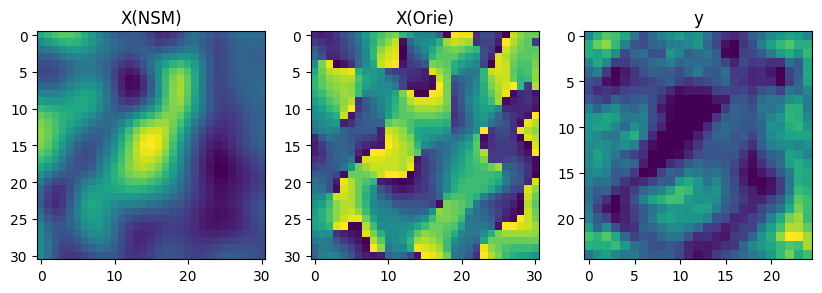

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.0213, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.1643, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.3233, device='cuda:0') tensor(0.8592, device='cuda:0')


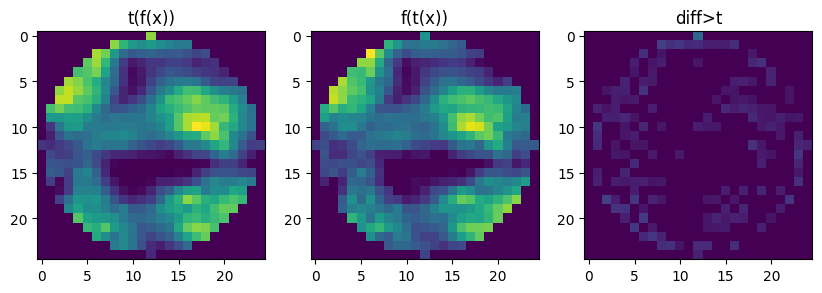

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.0216, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.1851, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2437, device='cuda:0') tensor(0.8387, device='cuda:0')


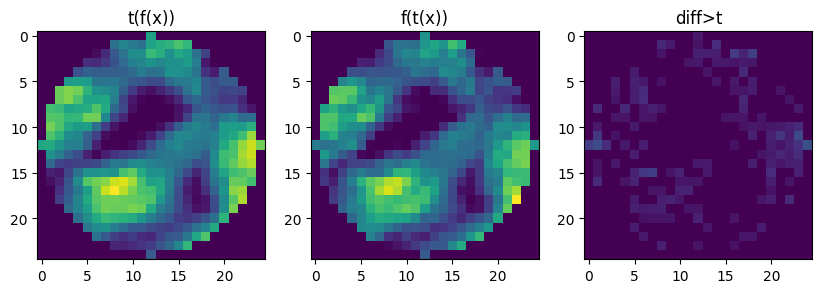

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.0416, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.2265, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2082, device='cuda:0') tensor(0.7690, device='cuda:0')


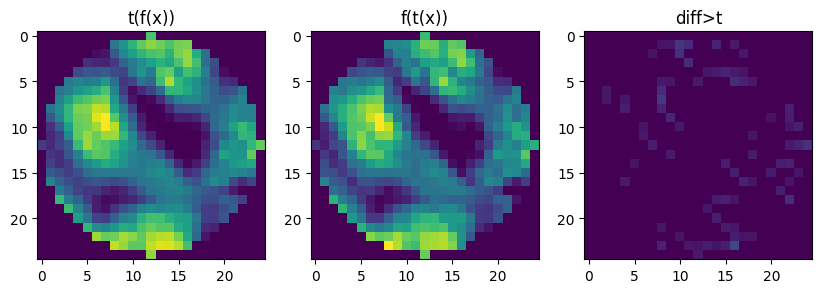

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.0428, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.0505, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.3020, device='cuda:0') tensor(0.8637, device='cuda:0')


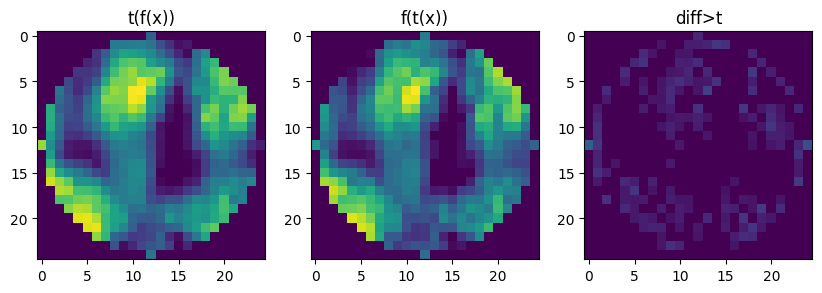

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.0269, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.1874, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2076, device='cuda:0') tensor(0.8669, device='cuda:0')


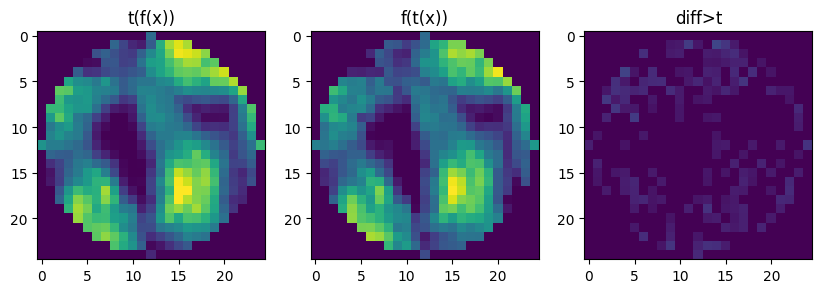

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.0269, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.1874, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2076, device='cuda:0') tensor(0.8669, device='cuda:0')


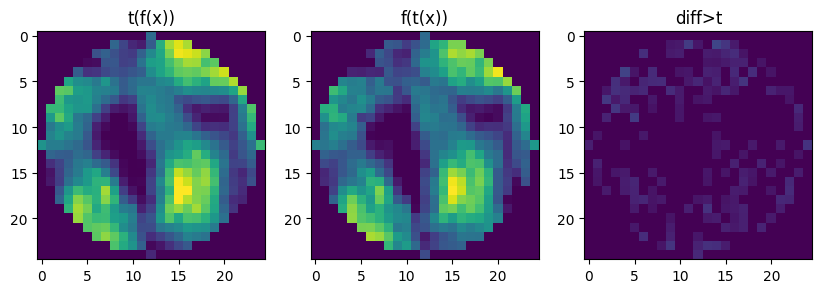

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.0066, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.0690, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1897, device='cuda:0') tensor(0.8289, device='cuda:0')


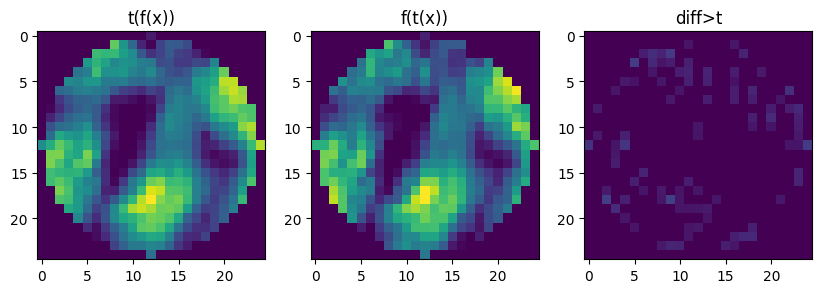

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.0328, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.2060, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.3310, device='cuda:0') tensor(0.8530, device='cuda:0')


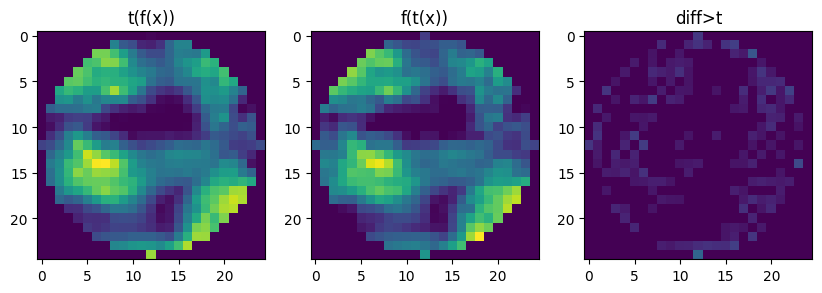

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.0424, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.0695, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2794, device='cuda:0') tensor(0.8636, device='cuda:0')


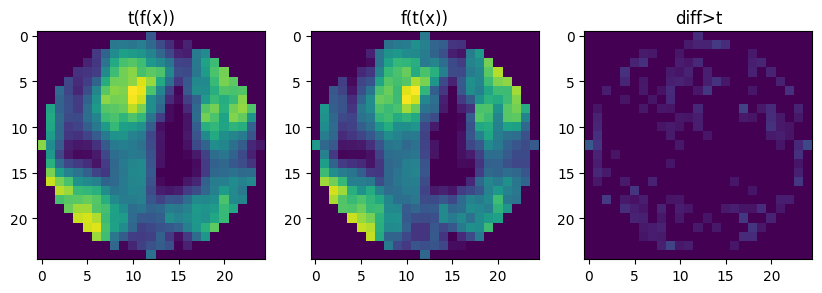

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.0439, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.1073, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1986, device='cuda:0') tensor(0.8635, device='cuda:0')


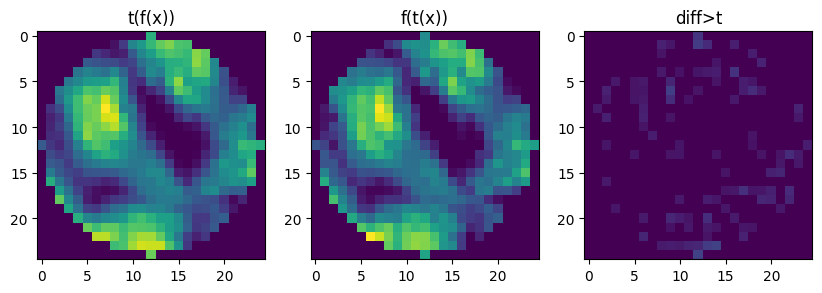

In [13]:
model_feature = model.feature
model_discriminator = model.discriminator

torch.manual_seed(42)
angles =  torch.tensor(np.random.uniform(low=0.0, high=360.0, size=10)//1, dtype=torch.float32).to(device)



iterator=iter(test_loader)
data = next(iterator)
index = 5 
with torch.no_grad():
    y = model_feature(data)
    c_mask = create_circular_mask(y.shape[2],y.shape[3])
    c_mask = torch.tensor(c_mask).to(device)

    show_images(normalize_tensor(data[index,0]),normalize_tensor(data[index,1]),normalize_tensor(y[index,0]),title1="X(NSM)",title2="X(Orie)",title3="y")
    for angle in angles:
        data_rotated, y_rotated = rotate_images(data, y, angle)
        y_rotated2 = model_feature(data_rotated)
        
        distance =model_discriminator(y_rotated,y_rotated2)
        y_rotated2 = y_rotated2*c_mask
        y_rotated = y_rotated*c_mask

        y1n=normalize_tensor(y_rotated[index,0])
        y2n=normalize_tensor(y_rotated2[index,0])

        print(y1n.min(),y_rotated.min(),y1n.max(),y_rotated.max())
        print(y2n.min(),y_rotated2.min(),y2n.max(),y_rotated2.max())
        
        diff = abs(y2n - y1n)
        t = 0.05
        diff[abs(diff) < t] = 0

        print(diff.min(),diff.max(),distance[0])
        show_images(y1n,y2n,diff,title1="t(f(x))",title2="f(t(x))",title3="diff>t")

In [14]:
def copy_tensor(tensor,times):
    tensor = tensor.repeat(times,1,1,1)
    return tensor

def matching_single_points(data1, data2, apply_random_transform=False):
    size = len(data1)
    matches = []

    with torch.no_grad():
        for i in range(len(data2)):
            img_temp = data2[i][None]

            if apply_random_transform:
                img_temp2 = random_transform(img_temp)
            else:
                img_temp2 = img_temp.clone()

            data_temp = copy_tensor(img_temp2, size)
            if apply_random_transform:
                data_temp = random_transform(data_temp)

            distances = model(data1, data_temp)
            match_index = distances.argmin().item()
            matches.append((i, match_index))
    print(matches)
    return np.array(matches)

            

matching_results = matching_single_points(data, data, apply_random_transform=True)
acertos = np.sum(matching_results[:, 0] == matching_results[:, 1])
print('total ',matching_results.shape[0],', acertos ',acertos,', matching pair ',matching_results)


# for (i,j) in matching_results[:10]:
#     print('i ',i,' j ',j)
#     plot_pair_image(data[i,0],data2[j,0],'feat_a {}'.format(i),'feat_b {}'.format(j))

[(0, 10), (1, 20), (2, 19), (3, 3), (4, 1), (5, 0), (6, 21), (7, 21), (8, 2), (9, 19), (10, 0), (11, 11), (12, 0), (13, 13), (14, 10), (15, 10), (16, 16), (17, 1), (18, 5), (19, 14), (20, 20), (21, 21), (22, 7), (23, 23), (24, 24)]
total  25 , acertos  8 , matching pair  [[ 0 10]
 [ 1 20]
 [ 2 19]
 [ 3  3]
 [ 4  1]
 [ 5  0]
 [ 6 21]
 [ 7 21]
 [ 8  2]
 [ 9 19]
 [10  0]
 [11 11]
 [12  0]
 [13 13]
 [14 10]
 [15 10]
 [16 16]
 [17  1]
 [18  5]
 [19 14]
 [20 20]
 [21 21]
 [22  7]
 [23 23]
 [24 24]]


### Comparar features de duas imagens



In [15]:
#plot pair image with tensor
def plot_pair_image(data1, data2, title1, title2):
    # vmin,vmax=0,1
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].imshow(data1.cpu().detach())
    ax[0].set_title(title1)
    ax[1].imshow(data2.cpu().detach())
    ax[1].set_title(title2)
    plt.show()

In [16]:
def plot_matches_keypoints(image1, keypoints1, image2, keypoints2, matches, **kwargs):
    # Concatenar as duas imagens lado a lado
    combined_image = np.concatenate((image1, image2), axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(combined_image, cmap='gray')
    ax.axis('off')

    # Desenhar pontos correspondentes e linhas conectando-os
    offset = image1.shape[1]

    for i, (x, y) in enumerate(keypoints1):
        ax.plot(x, y, 'o',markerfacecolor='none', markeredgecolor='r',
                markersize=20, markeredgewidth=1)
        ax.annotate(str(i), (x, y), color='r',xytext=(10, 10), textcoords='offset points', fontsize=12)

    for i, (x, y) in enumerate(keypoints2):
        ax.plot(x+offset, y, 'o',markerfacecolor='none', markeredgecolor='r',
                markersize=20, markeredgewidth=1)
        ax.annotate(str(i), (x+offset, y), color='r',xytext=(10, 10), textcoords='offset points', fontsize=12)

    for match in matches:
        x1, y1 = keypoints1[match[0],0], keypoints1[match[0],1]
        x2, y2 = keypoints2[match[1],0]+offset, keypoints2[match[1],1]
        ax.plot([x1, x2], [y1, y2], '-', color='lime', lw=0.5)

    plt.tight_layout()
    plt.show()


def plot_matches_by_coord(image1, coords1, image2, coords2, matches, **kwargs):
    import numpy as np
    import matplotlib.pyplot as plt

    # Concatenar as duas imagens lado a lado
    combined_image = np.concatenate((image1, image2), axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(combined_image, cmap='gray')
    ax.axis('off')

    # Desenhar pontos correspondentes e linhas conectando-os
    offset = image1.shape[1]
    ax.plot(coords1[0, :], coords1[1, :], 'o',
            markerfacecolor='none', markeredgecolor='r',
            markersize=20, markeredgewidth=1)
    ax.plot(coords2[0, :] + offset, coords2[1, :], 'o',
            markerfacecolor='none', markeredgecolor='r',
            markersize=20, markeredgewidth=1)

    for i, (x, y) in enumerate(zip(coords1[0, :], coords1[1, :])):
        ax.annotate(str(i), (x, y),
                    textcoords="offset points", xytext=(0, 10),
                    color='red', ha='center', fontsize=13)

    for i, (x, y) in enumerate(zip(coords2[0, :], coords2[1, :])):
        ax.annotate(str(i), (x + offset, y),
                    textcoords="offset points", xytext=(0, 10),
                    color='red', ha='center', fontsize=13)

    for match in matches:
        x1, y1 = coords1[0, match[0]], coords1[1, match[0]]
        x2, y2 = coords2[0, match[1]] + offset, coords2[1, match[1]]
        ax.plot([x1, x2], [y1, y2], '-', color='lime', lw=0.5)

In [17]:
#exibe duas imagens lado a lado com matplotlib com dois titulos
def imshow2(img1,img2,coords=None,t1="0",t2="1",figsize=(15,10)):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(img1)
    ax1.title.set_text(t1)
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(img2)
    ax2.title.set_text(t2)
    if coords is not None:
        ax1.plot(coords[0,:],coords[1,:], 'r+')
        ax2.plot(coords[0,:],coords[1,:], 'r+')
        # zip joins x and y coordinates in pairs
        labels = np.arange(coords.shape[1])
        for i, (x,y) in enumerate(zip(coords[0,:],coords[1,:])):
            ax1.annotate(labels[i], # this is the text
                (x,y), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                color='white',
                ha='center') # horizontal alignment can be left, right or center
            
            ax2.annotate(labels[i], # this is the text
                (x,y), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                color='white',
                ha='center') # horizontal alignment can be left, right or center
    plt.show()

15 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
1 tensor([0])


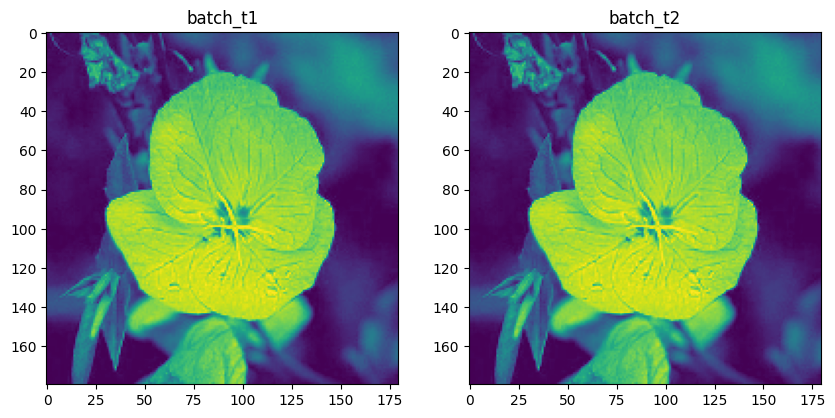

mini_dataloader  torch.Size([12, 2, 31, 31]) torch.Size([1, 3, 12])


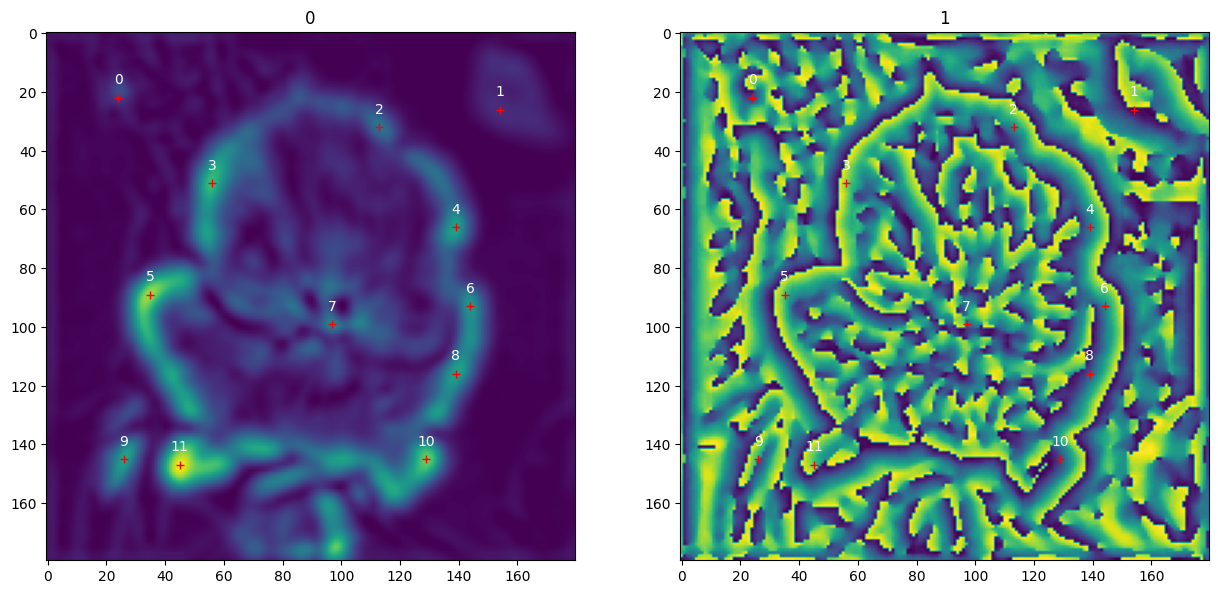

mini_dataloader  torch.Size([12, 2, 31, 31]) torch.Size([1, 12, 2])


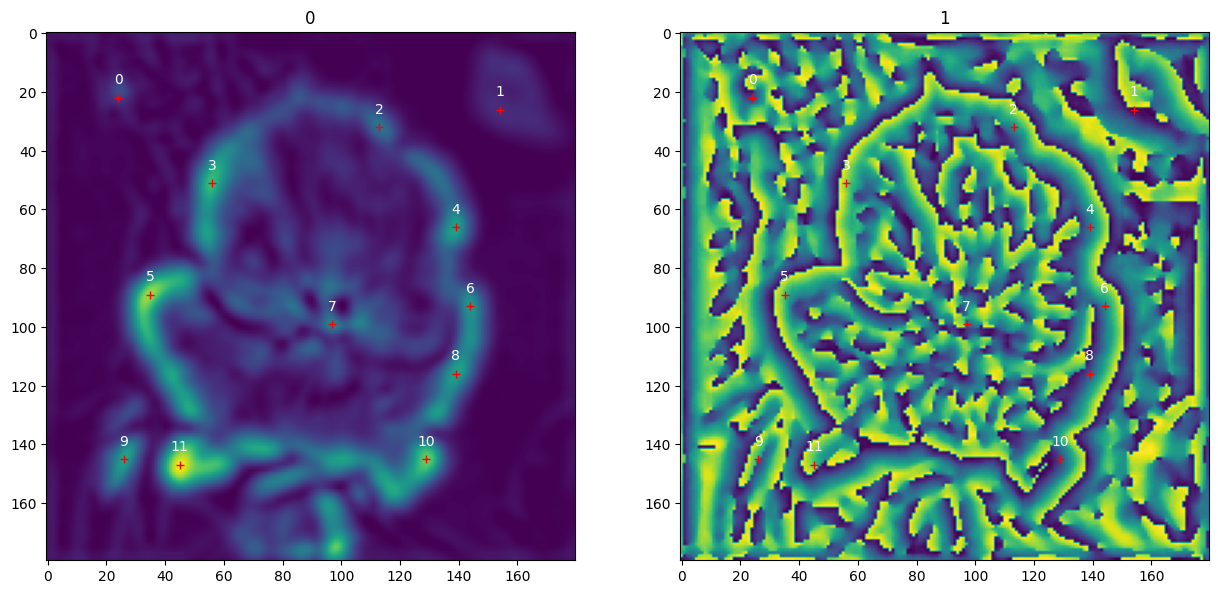

In [18]:
args.nms_size = 30


img_batch, labels =batch
print(len(img_batch),labels) #4

batch_t1 =(img_batch[:1],labels[:1])
img_batch1, labels1 =batch_t1
print(len(img_batch1),labels1) #1

#rotaciona batch_t1
img_batch2 = random_transform(img_batch1)
batch_t2 = (img_batch2,labels1)

plot_pair_image(img_batch1[0,0],img_batch2[0,0],'batch_t1','batch_t2')

#find single point of batch_t2 and batch_t1
feature_t1,orien_t1 = predict_single_points(single_point_model,batch_t1)
batch_result_t1,coords_t1 = extract_features_with_box(feature_t1,orien_t1)
mini_dataloader_t1 = concatenate_mini_batches_feat_orien(batch_result_t1)
points_t1 = coords_t1[:, :2].transpose(1, 2)
print('mini_dataloader ',mini_dataloader_t1.shape,coords_t1.shape)

imshow2(feature_t1[0,0].cpu().detach(),orien_t1[0,0].cpu().detach(),coords_t1[0,:,:17])

feature_t2,orien_t2 = predict_single_points(single_point_model,batch_t2)
batch_result_t2,coords_t2 = extract_features_with_box(feature_t2,orien_t2)
mini_dataloader_t2 = concatenate_mini_batches_feat_orien(batch_result_t2)
points_t2 = coords_t2[:, :2].transpose(1, 2)
print('mini_dataloader ',mini_dataloader_t2.shape,points_t2.shape)
imshow2(feature_t2[0,0].cpu().detach(),orien_t2[0,0].cpu().detach(),coords_t2[0,:,:17])

[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11)]
matching pair  (12, 2)


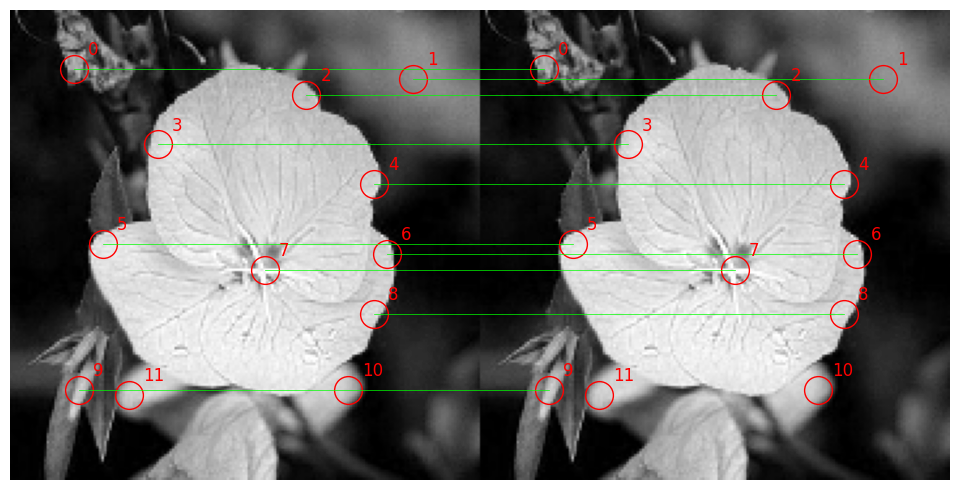

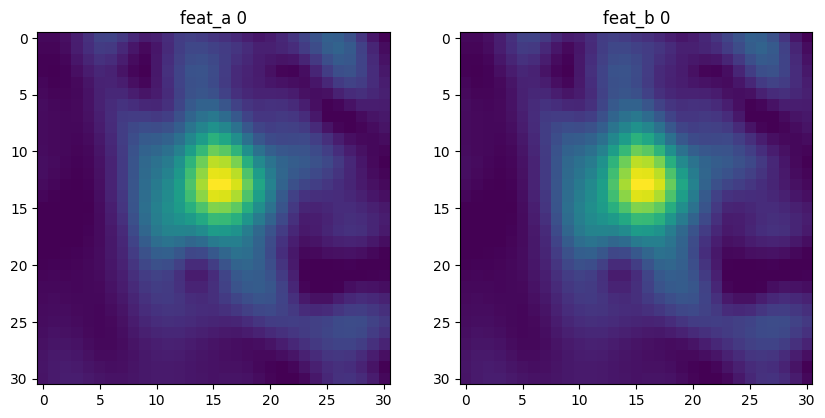

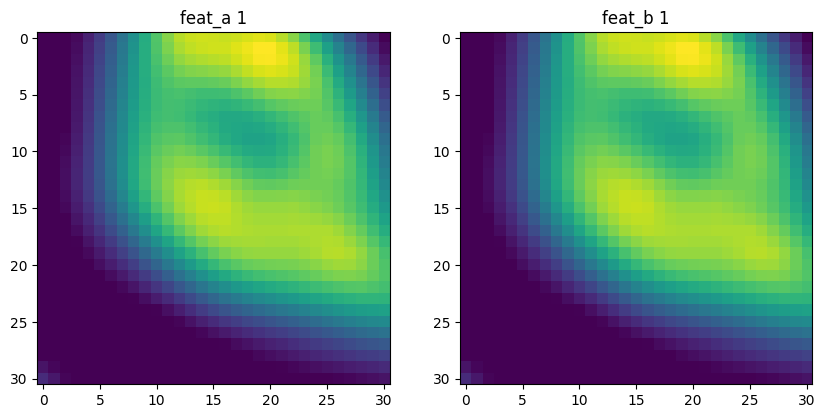

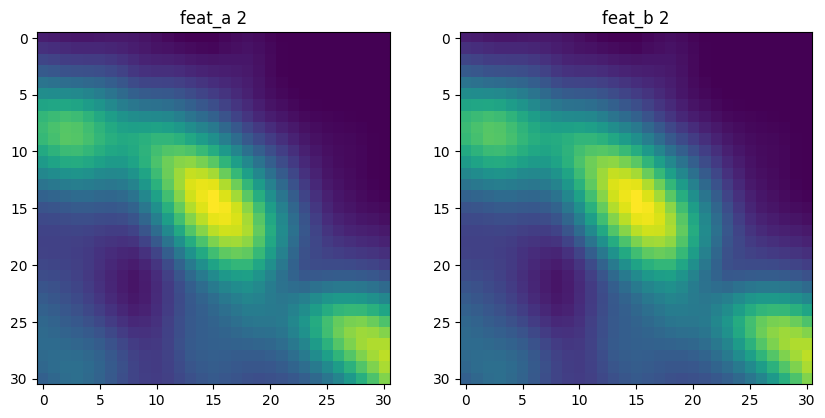

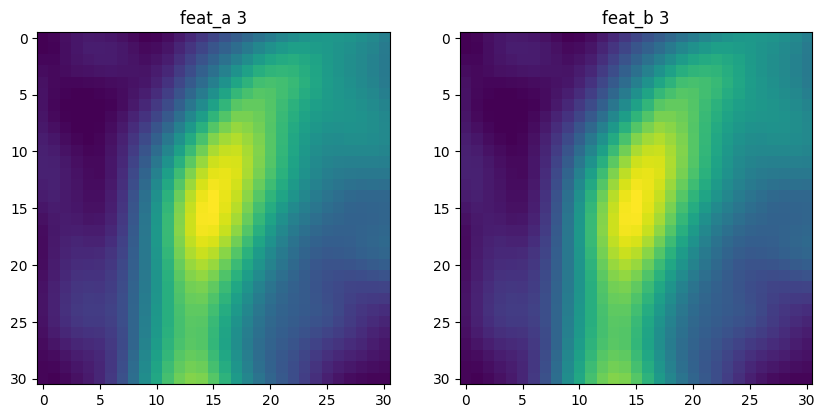

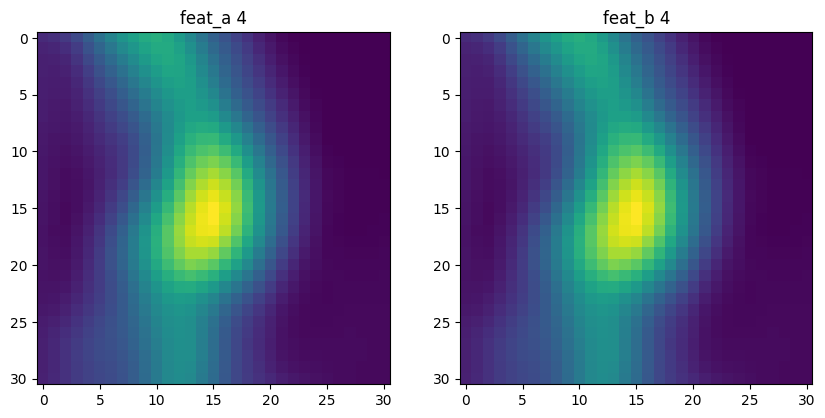

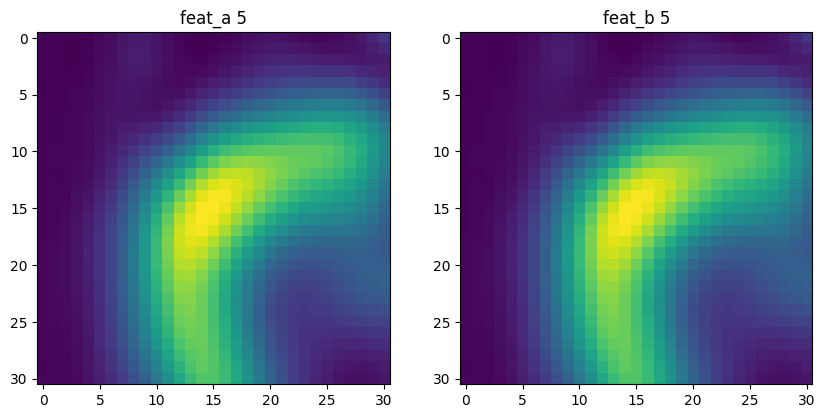

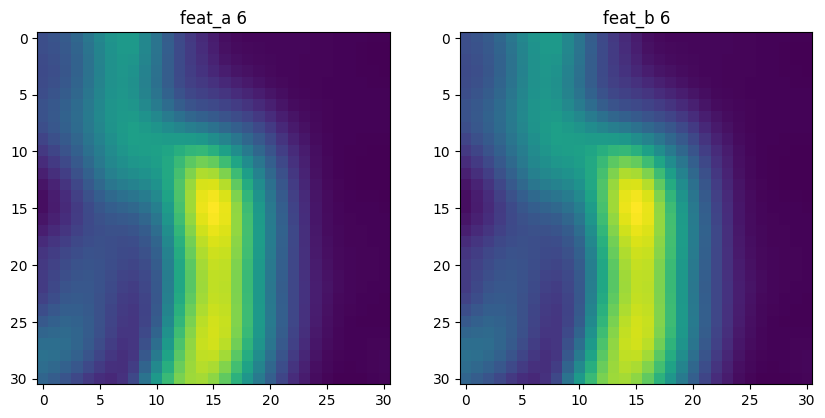

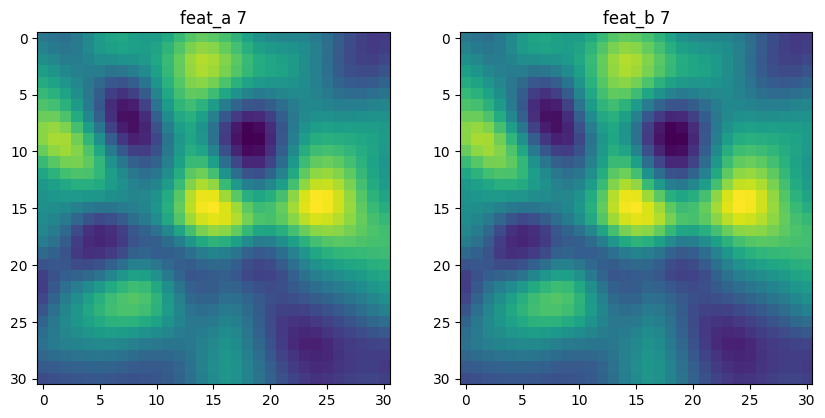

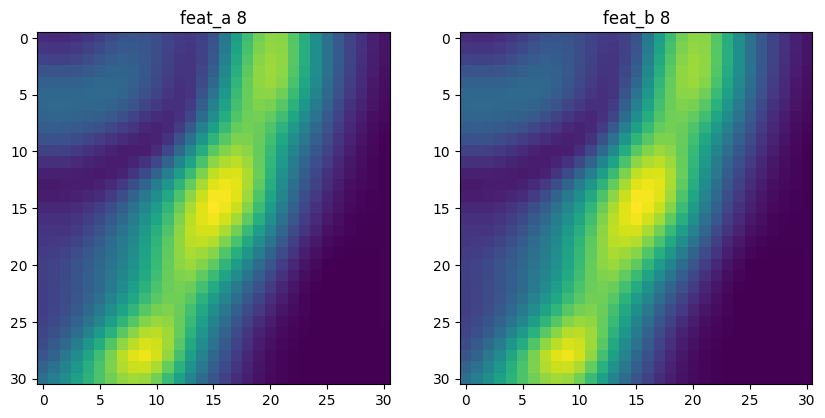

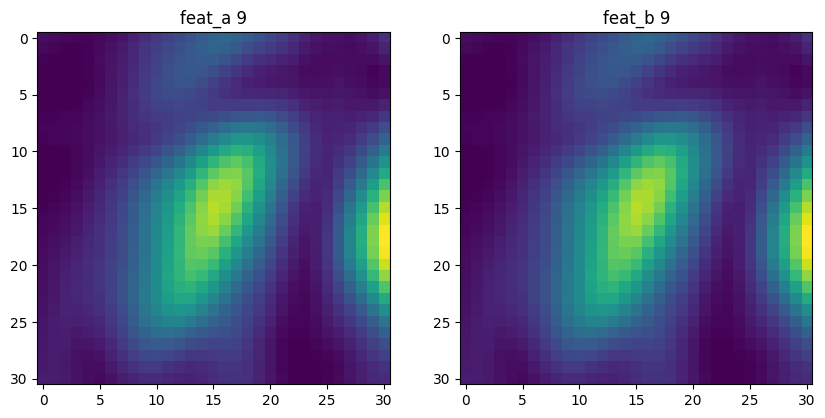

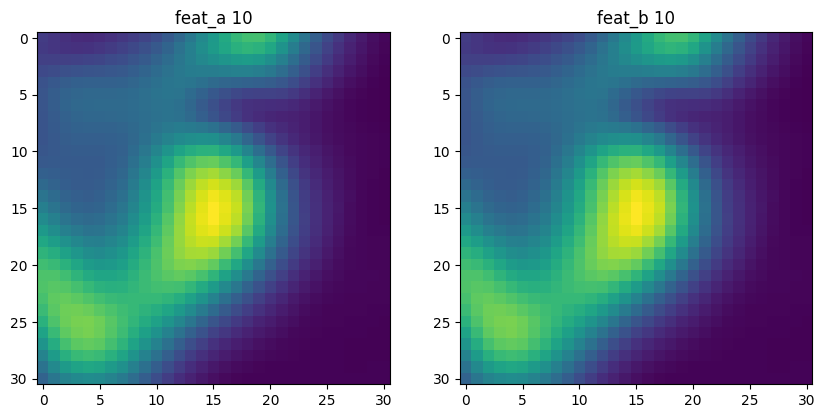

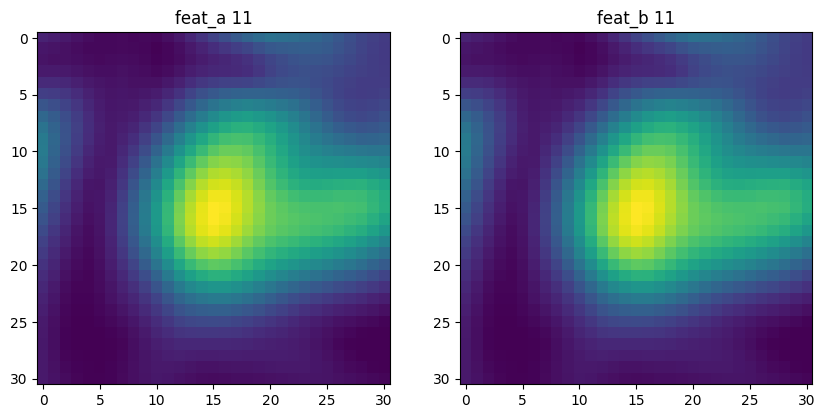

In [19]:



matching_results = matching_single_points(mini_dataloader_t1, mini_dataloader_t2, apply_random_transform=False)

print('matching pair ',matching_results.shape)

plot_matches_keypoints(img_batch1[0,0], points_t1[0],img_batch2[0,0], points_t2[0], matching_results[:10])
for i in range(mini_dataloader_t1.shape[0]):
    plot_pair_image(mini_dataloader_t1[i,0],mini_dataloader_t2[i,0],'feat_a {}'.format(i),'feat_b {}'.format(i))

In [20]:
import torch
import kornia.augmentation as K


# Criando uma sequência de transformações
transformations = K.AugmentationSequential(
    K.RandomAffine(degrees=90, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=10),
    data_keys = ['input', 'keypoints']  # Especificando as chaves de dados
)
# Criando uma imagem de exemplo e coordenadas correspondentes
input_image = img_batch1
keypoints = torch.tensor([[[40, 50], [95, 100], [130, 130]]], dtype=torch.float32)


# Aplicando o aumento de dados nas imagens e coordenadas
augmented_image,augmented_keypoints = transformations(input_image, keypoints)

print(keypoints.shape,augmented_keypoints.shape)
print(keypoints,augmented_keypoints)
# Fazer array de matches entre arrays de coordenadas e coordenadas aumentadas
matching_results =[[i, i] for i in range(keypoints.shape[1])]


torch.Size([1, 3, 2]) torch.Size([1, 3, 2])
tensor([[[ 40.,  50.],
         [ 95., 100.],
         [130., 130.]]]) tensor([[[ 24.9654, 119.4221],
         [ 95.2858,  99.4400],
         [138.4756,  85.6132]]])


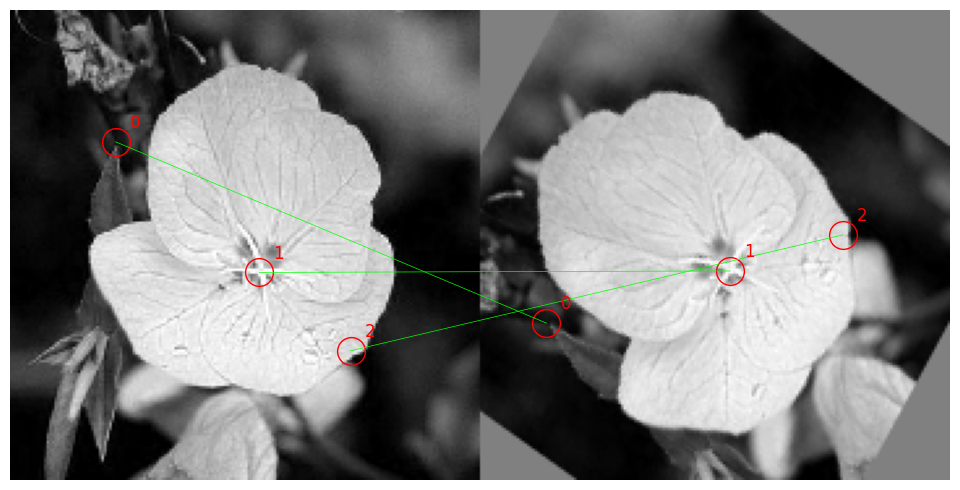

In [21]:


plot_matches_keypoints(input_image[0,0], keypoints[0], augmented_image[0,0], augmented_keypoints[0], matching_results[:10])